  # HOUSING PRICES

# 1- Preparation

## 1.1- Import modules

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import getcwd 
from sklearn.linear_model import LinearRegression
from sklearn import neighbors 
from sklearn.model_selection import train_test_split

## 1.2- Load data

In [26]:
# the data is located in the same folder as the working directory
filename = getcwd() + '/house_data.csv'
df = pd.read_csv(filename)
print('y: {0}   \nX: {1}'.format(df.columns[0], [df.columns[1], df.columns[2]]))
print('matrix size: {0}'.format(df.shape))

y: price   
X: ['surface', 'arrondissement']
matrix size: (827, 3)


## 1.3- Data clean up

In [27]:
# remove the nan:
df = df.dropna(axis=0)
df.index = np.arange(0, df.shape[0])   # re-index

## 1.4- Data exploration

Note that:
    - all arrondissements are not represented
    - there maybe a few outliers in prices and surface

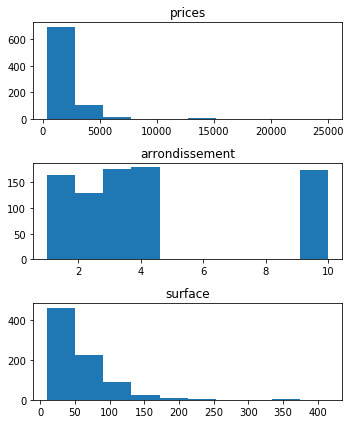

In [28]:
# plot the data
plt.ion()
plt.figure(figsize=(5, 6))
plt.subplot(3, 1, 1)
plt.title('prices')
plt.hist(df.price)

plt.subplot(3, 1, 2)
plt.title('arrondissement')
plt.hist(df.arrondissement)

plt.subplot(3, 1, 3)
plt.title('surface')
plt.hist(df.surface)

plt.tight_layout()
plt.show()

## 1.5- Preping the data for machine learning

In [29]:
# organize the data
df['ones'] = pd.DataFrame(np.ones(df.shape[0]))  # add the ones column
df = df[['price', 'ones', 'surface', 'arrondissement']]
# define target and features
y = df.price.as_matrix()
X = df[['ones', 'surface', 'arrondissement']].as_matrix()
# separate test and train set
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

# 2- Machine learning

## 2.1- Functions

### 2.1.1- Regression function

In [30]:
def regress(xtrain, ytrain, xtest, ytest):
    """return coeff, error and prediction
    """
    import warnings
    warnings.filterwarnings(
        action="ignore", module="scipy", message="^internal gelsd")
    regressor = LinearRegression()
    regressor.fit(xtrain, ytrain)
    # error
    error = np.round(100 - 100*regressor.score(xtest, ytest), 4)
    # coefficient
    c = pd.DataFrame(regressor.coef_)
    # results
    results = pd.DataFrame(regressor.predict(xtest))
    y = pd.DataFrame(ytest)
    r = pd.concat((pd.DataFrame(xtest[:,1:]), y, results), axis=1)
    results = pd.concat((r, y-results), axis=1)
    return c, error, results

### 2.1.2- Helpers

We define 3 helpers functions for the repetitive tasks: 
    - printMe(.): to show in same format
    - one_hot(.): to arrange the arrondissements in columns with show by default
    - remove_outliers(.): remove outliers with thresholds defined by default


In [31]:
def printMe(show=5):
    print('linear regression coefficients: \n{0}'.format(c))
    print('\nerror: {0}'.format(e))
    show = show
    print('\nfirst {0} data points with their prediction: \n{1}'.
          format(show, m.head(show)))
    print('\nlast {0} data points with their prediction: \n{1}'.
          format(show, m.tail(show)))


def one_hot(x):
    x2 = x[:, [0,1]]
    d = pd.DataFrame(x[:,2])   # the arrondissement column into a DF
    for a in range(1, 11):
        d[a] = pd.DataFrame(np.where(d[0] == a, 1, 0))
    x2 = np.concatenate([x2, d.iloc[:, 1:]], axis=1)   # so lazy!
    return x2


def remove_outliers(X, Y, threshold_price=5000, threshold_surface=100):
    df = pd.DataFrame(np.concatenate([np.matrix(Y).T, X], axis=1))
    df = df.where(df[0] < threshold_price, np.nan)
    df = df.where(df[2] < threshold_surface, np.nan)
    df = df.dropna()
    df.index = np.arange(0, df.shape[0])   # re-index
    return df.loc[:,1:].as_matrix(), df[0].as_matrix()


## 2.2- The base case

We apply the regression to the data set as such without any modifications.

In [32]:
# BASE CASE
print('\n\n-------------------------------------------------')    
print('BASE CASE')
print('-------------------------------------------------')
c, e, m = regress(xtrain, ytrain, xtest, ytest)
c.index = ['ones', 'surface', 'arrondissement']
c.columns = ['coefficient']
m.columns = ['surface', 'arrondissement', 'true_value', 'prediction', 'error']
# print results
printMe()



-------------------------------------------------
BASE CASE
-------------------------------------------------
linear regression coefficients: 
                coefficient
ones               0.000000
surface           37.028976
arrondissement   -40.728801

error: 35.7843

first 5 data points with their prediction: 
   surface  arrondissement  true_value   prediction       error
0    65.00             4.0        2300  2275.877319   24.122681
1    25.24            10.0         780   559.232447  220.767553
2    44.53             1.0        1404  1640.080591 -236.080591
3    55.00             3.0        1520  1946.316364 -426.316364
4    71.00             1.0        1910  2620.237574 -710.237574

last 5 data points with their prediction: 
     surface  arrondissement  true_value   prediction        error
160    27.98             2.0        1118   986.522245   131.477755
161    20.90            10.0         820   398.526693   421.473307
162    70.90             1.0        2300  2616.534677

## 2.3- One-hot

As the arrondissement should pertain more to a category, 
we arrange the column arrondissement such as: 
    - we add as many columns as we have arrondissements
    - each new arrondissement column contain 0 or 1 as the row pertains to that arrondissement (1) or not (0)
    - we remove the arrondissement column

In [33]:
# ONE-HOT
# we need to change the arrondissement column to a series of columns
# whose title will be the arrondissement number, and containing
# - 1 if the columns pertains to the arrondissement column title
# - 0 otherwise
print('\n\n-------------------------------------------------')
print('ONE-HOT')
print('-------------------------------------------------')
xtrain2 = one_hot(xtrain)
xtest2 = one_hot(xtest)
c, e, m = regress(xtrain2, ytrain, xtest2, ytest)
# formating for print
arr_labels = [str(i) + ' arrondissement' for i in range(1,11)]
c.index = ['ones', 'surface'] + arr_labels
c.columns = ['coefficient']
# re-work m to have only the columns we need
m = m.iloc[:, [0, 11, 12, 13]]   # the columms we need
m.columns = ['surface', 'true_value', 'prediction', 'error']
m['arrondissement'] = pd.DataFrame(xtest[:,2])
# put columns in the order we like
m = m[['surface', 'arrondissement', 'true_value', 'prediction', 'error']]
# print results
printMe()



-------------------------------------------------
ONE-HOT
-------------------------------------------------
linear regression coefficients: 
                   coefficient
ones                  0.000000
surface              36.871610
1 arrondissement    106.485432
2 arrondissement     67.814370
3 arrondissement    -41.951821
4 arrondissement    139.685886
5 arrondissement      0.000000
6 arrondissement      0.000000
7 arrondissement      0.000000
8 arrondissement      0.000000
9 arrondissement      0.000000
10 arrondissement  -272.033867

error: 35.7995

first 5 data points with their prediction: 
   surface  arrondissement  true_value   prediction       error
0    65.00             4.0        2300  2413.012439 -113.012439
1    25.24            10.0         780   535.277468  244.722532
2    44.53             1.0        1404  1625.050126 -221.050126
3    55.00             3.0        1520  1862.658631 -342.658631
4    71.00             1.0        1910  2601.041646 -691.041646

last 5 d

## 2.4- Remove the outliers

We remove the rows that we feel may perturb our machine learning.
Essentially we remove any row for which: 
    - price > 5000
    - surface > 100

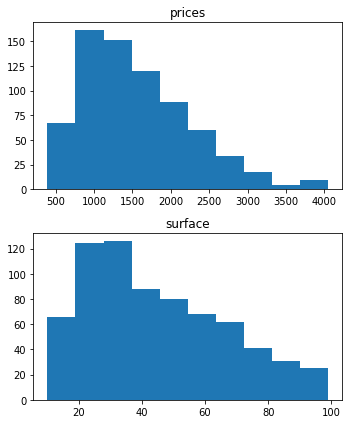

In [34]:
XX, YY = remove_outliers(X, y)
gf = pd.DataFrame(np.concatenate([np.matrix(YY).T, XX], axis=1))
gf.columns = ['price', 'ones', 'surface', 'arrondissement']

# plot the data without the outliers
plt.figure(figsize=(5, 6))
plt.subplot(2, 1, 1)
plt.title('prices')
plt.hist(gf.price)

plt.subplot(2, 1, 2)
plt.title('surface')
plt.hist(gf.surface)

plt.tight_layout()
plt.show()

## 2.4.1- Remove outliers from the base case

In [35]:
# remove the outliers from base case
print('\n\n-------------------------------------------------')
print('REMOVE THE OUTLIERS FROM BASE CASE')
print('-------------------------------------------------')
xtrain3, ytrain3 = remove_outliers(xtrain, ytrain)
xtest3, ytest3 = remove_outliers(xtest, ytest)
c, e, m = regress(xtrain3, ytrain3, xtest3, ytest3)
# formating
c.index = ['ones', 'surface', 'arrondissement']
c.columns = ['coefficient']
m.columns = ['surface', 'arrondissement', 'true_value', 'prediction', 'error']
# print results
printMe()



-------------------------------------------------
REMOVE THE OUTLIERS FROM BASE CASE
-------------------------------------------------
linear regression coefficients: 
                coefficient
ones               0.000000
surface           26.191637
arrondissement   -41.493557

error: 22.7525

first 5 data points with their prediction: 
   surface  arrondissement  true_value   prediction       error
0    65.00             4.0      2300.0  2092.625290  207.374710
1    25.24            10.0       780.0   802.284475  -22.284475
2    44.53             1.0      1404.0  1680.963162 -276.963162
3    55.00             3.0      1520.0  1872.202482 -352.202482
4    71.00             1.0      1910.0  2374.255782 -464.255782

last 5 data points with their prediction: 
     surface  arrondissement  true_value   prediction       error
135    64.00             3.0      1850.0  2107.927211 -257.927211
136    23.00             3.0      1250.0  1034.070112  215.929888
137    27.98             2.0   

## 2.4.1- Remove outliers from the one_hot

In [36]:
# remove the outliers from one hot
print('\n\n-------------------------------------------------')
print('REMOVE THE OUTLIERS FROM ONE-HOT')
print('-------------------------------------------------')
xtrain4, ytrain4 = one_hot(xtrain3), ytrain3
xtest4, ytest4 = one_hot(xtest3), ytest3
c, e, m = regress(xtrain4, ytrain4, xtest4, ytest4)
# formating for print
arr_labels = [str(i) + ' arrondissement' for i in range(1,11)]
c.index = ['ones', 'surface'] + arr_labels
c.columns = ['coefficient']
# re-work m to have only the columns we need
m = m.iloc[:, [0, 11, 12, 13]]   # the columms we need
m.columns = ['surface', 'true_value', 'prediction', 'error']
m['arrondissement'] = pd.DataFrame(xtest4[:,2])
# put columns in the order we like
m = m[['surface', 'arrondissement', 'true_value', 'prediction', 'error']]
# print results
printMe()

                           




-------------------------------------------------
REMOVE THE OUTLIERS FROM ONE-HOT
-------------------------------------------------
linear regression coefficients: 
                   coefficient
ones                  0.000000
surface              25.657500
1 arrondissement    215.968648
2 arrondissement     -6.386825
3 arrondissement    -17.841573
4 arrondissement     53.172777
5 arrondissement      0.000000
6 arrondissement      0.000000
7 arrondissement      0.000000
8 arrondissement      0.000000
9 arrondissement      0.000000
10 arrondissement  -244.913027

error: 22.0346

first 5 data points with their prediction: 
   surface  arrondissement  true_value   prediction       error
0    65.00             0.0      2300.0  2132.873709  167.126291
1    25.24             0.0       780.0   814.645701  -34.645701
2    44.53             1.0      1404.0  1770.460553 -366.460553
3    55.00             0.0      1520.0  1805.284358 -285.284358
4    71.00             1.0      1910.0  2449.614

# Conclusion: need for more data!

Although we see that the One-Hot approach brought somewhat better prediction
errors we note also that if we run the training several times, it so happens that 
the improvement is sometimes actually worsening the prediction.
Also, the improvement is a little further when we remove the price and surface outliers, but not always.

But overall, we were unable to dramatically improve the prediction.
So it means that we really need to have more data points:
    - more arrondissements
    - more data points per arrondissements